In [1]:
import vof
from vof import forecaster
from vof import optimizer

In [2]:
#pip install altair

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

In [42]:
data = pd.read_csv("data/district/predictions_2019.csv", index_col=0, parse_dates=True)#pd.read_csv('sales_FOODS_3_090_TX_2.csv')
data.head(5)

,Prophet 30d,CB Model 30d,Prophet 60d,LR Model 240d,LR Model 30d,LR Model 60d,LR Model 120d,Prophet 120d,Theta 30d,Theta 60d,Theta 120d,Theta 240d,CB Model 60d,CB Model 240d,CB Model 120d,Prophet 240d,Fact,SNaive
Time,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,9.712369,9.516061,9.732844,10.082039,10.034193,9.860739,9.931228,9.475604,9.992034,9.986460,10.074619,10.037784,9.478454,9.477245,9.469355,9.521947,9.791285,9.587180
2019-01-02 01:00:00,9.537794,9.329764,9.526740,9.905469,9.848606,9.685257,9.755594,9.250441,9.799050,9.784246,9.843274,9.809841,9.314212,9.310756,9.320833,9.283847,9.595427,9.421677
2019-01-02 02:00:00,9.346844,9.225298,9.357172,9.752310,9.685450,9.537204,9.604944,9.048528,9.646126,9.618324,9.656499,9.620984,9.217455,9.230141,9.192942,9.021519,9.538146,9.302606
2019-01-02 03:00:00,9.238202,9.140338,9.258282,9.633302,9.547768,9.422706,9.488390,8.965614,9.534998,9.506044,9.530117,9.501419,9.155913,9.161070,9.141137,8.909141,9.420105,9.151197
2019-01-02 04:00:00,9.222486,9.122567,9.222533,9.600721,9.502948,9.403288,9.459666,8.902531,9.499663,9.469673,9.476750,9.455269,9.125739,9.136762,9.136573,8.850692,9.364424,9.159970


# Creating forecast from Fact data

We start with creating a forecaster oblect from data['Fact'] with target mentric (the one to predict) also equal to 'Fact'

In [43]:
tmp = forecaster.RecursiveForecaster(data[['Fact']], 
                          target='Fact')
tmp.y

Time
2019-01-02 00:00:00     9.791285
2019-01-02 01:00:00     9.595427
2019-01-02 02:00:00     9.538146
2019-01-02 03:00:00     9.420105
2019-01-02 04:00:00     9.364424
                         ...    
2019-12-31 19:00:00    12.082850
2019-12-31 20:00:00    11.582850
2019-12-31 21:00:00    11.257850
2019-12-31 22:00:00    10.887850
2019-12-31 23:00:00    10.482850
Name: Fact, Length: 8736, dtype: float64

## Estimating Lags and adding them to the object

In [44]:
def estimateSignificantLags(ts, nlags = 360, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[  1   2   3   5  23  24  26  50 168 169]


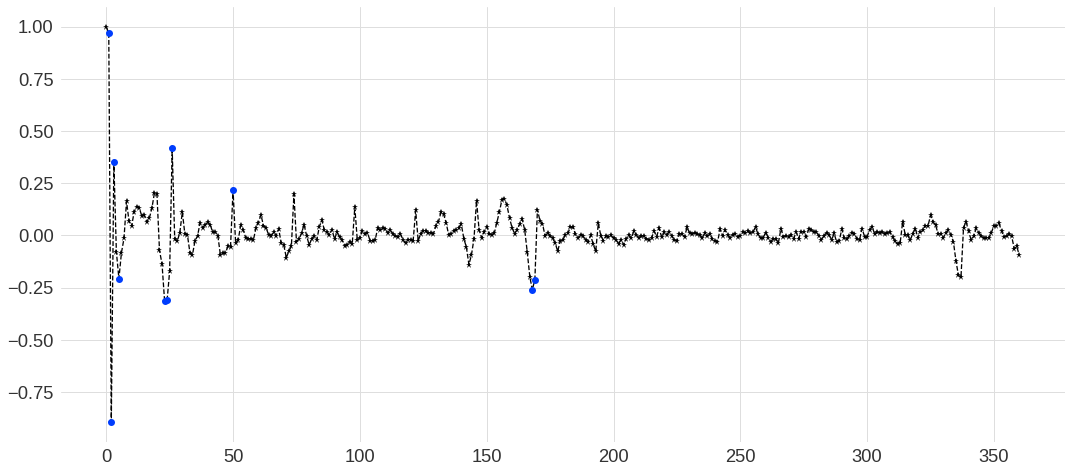

In [45]:
lags = estimateSignificantLags(tmp.y, significantLags = 10)
# add lags for certain days
lags = np.unique(np.hstack([lags]))
print(np.sort(lags))

In [46]:
tmp.add_lag_features(np.sort(lags))

In [47]:
tmp.x.head(5)

,lag_1,lag_2,lag_3,lag_5,lag_23,lag_24,lag_26,lag_50,lag_168,lag_169
Time,,,,,,,,,,
2019-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 01:00:00,9.791285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 02:00:00,9.595427,9.791285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 03:00:00,9.538146,9.595427,9.791285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 04:00:00,9.420105,9.538146,9.595427,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Now the dataset is ready, so we can start building a dataframe with different predictions for further optimization.
All predictions will be in the same dataframe optimization_df together with the Fact data.
We run several prediction models

In [48]:
models = {'LR': linear_model.LinearRegression(),
          'CB': CatBoostRegressor(verbose=False,learning_rate = 0.01,depth=6,l2_leaf_reg=4),
          'RF': RandomForestRegressor(),
          'LGBM': lgb.LGBMRegressor()}

optimization_df = pd.DataFrame()

for model in models.keys():
    
    pred_df = tmp.create_recursive_prediction(models[model],
                      start_day='2019-01-12',
                      last_known_day='2019-03-01',
                      prediction_day='2019-03-02',
                      terminal_day='2019-04-01',
                      freq='H',
                      h=72).melt(ignore_index=False).reset_index().set_index(['variable','index']).dropna()

    pred_df['model'] = str(models[model])
    optimization_df = optimization_df.append(pred_df)
    
optimization_df.reset_index(inplace=True)
optimization_df.columns = ['prediction_date','ts','value','model']

LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
LinearRegression()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
RandomForestRegressor()
Ran

In [62]:
optimization_df.head()

,prediction_date,ts,value,model
0,2019-03-02,2019-03-02 00:00:00,10.933166,LinearRegression()
1,2019-03-02,2019-03-02 01:00:00,10.718831,LinearRegression()
2,2019-03-02,2019-03-02 02:00:00,10.538434,LinearRegression()
3,2019-03-02,2019-03-02 03:00:00,10.42515,LinearRegression()
4,2019-03-02,2019-03-02 04:00:00,10.421619,LinearRegression()


In [64]:
fact = optimization_df.loc[optimization_df.model=='LGBMRegressor()'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index('ts', inplace=True)
fact['model'] = 'Fact'
fact['value'] = tmp.y.loc[fact.index]
fact.reset_index(inplace=True)
optimization_df = optimization_df.append(fact)

In [65]:
alt.data_transformers.disable_max_rows()

alt.Chart(optimization_df).mark_line().encode(
    x='ts:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('prediction_date:N', legend=None),
    row='model:N'
).properties(width=600, height=150).interactive()

alt.Chart(...)

# Optimizer to choose from several predictions

Predictions are ready. Now we are creating a child class for Electricity Peak Case. 
We need the child class to pass there task-specific cost functions and other constant values like PEAK_POWER_LIMIT, BATTERY_CHARGE, BATTERY_CAPACITY end so on

In [66]:
optimization_df.loc[(optimization_df.prediction_date=='2019-03-31T00:00:00.000000000')&(optimization_df.model=='LinearRegression()')]

,prediction_date,ts,value,model
2088,2019-03-31,2019-03-31 00:00:00,10.731673,LinearRegression()
2089,2019-03-31,2019-03-31 01:00:00,10.503319,LinearRegression()
2090,2019-03-31,2019-03-31 02:00:00,10.267669,LinearRegression()
2091,2019-03-31,2019-03-31 03:00:00,10.091012,LinearRegression()
2092,2019-03-31,2019-03-31 04:00:00,10.023496,LinearRegression()
2093,2019-03-31,2019-03-31 05:00:00,10.028749,LinearRegression()
2094,2019-03-31,2019-03-31 06:00:00,10.058087,LinearRegression()
2095,2019-03-31,2019-03-31 07:00:00,10.22406,LinearRegression()
2096,2019-03-31,2019-03-31 08:00:00,10.596263,LinearRegression()
2097,2019-03-31,2019-03-31 09:00:00,10.993014,LinearRegression()


In [67]:
optimization_df = optimization_df.set_index('ts').join(tmp.y, how='left')

In [68]:
class OptimalDecisionMakersElectricityPeak(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 72#168
        self.DECISION_TIMESTEP = 24
        self.PEAK_POWER_LIMIT = 13
        self.BATTERY_CHARGE = 0
        self.BATTERY_CAPACITY = 1000
        self.BATTERY_EFFICIENCY = .99
        self.INVERTER_CAPACITY = 80
        
    def cost_function(self,solution,battery_charge):
        #print(battery_charge)
        cumsum = np.cumsum(solution) + battery_charge

        #battery capacity penalty:
        violations_battery = (np.sum(np.where(cumsum>self.BATTERY_CAPACITY)) + np.sum(np.where(cumsum<0))) * 10000
        
        
        #penalty for putting electricity back to the grid
        if self.EVALUATE:
            grid_load = (self.y+solution).values
        else:
            #print(self.candidate.shape)
            grid_load = (self.candidate+solution).values
        
        violations_demand = -np.sum(grid_load[np.where(grid_load<0)]) * 10000

        #penlty for high peak in load
        margin = (self.PEAK_POWER_LIMIT - grid_load)
        violations_peak = -np.sum(margin[np.where(margin < 0)]) * 10000

        #penalty for battery losses
        battery_usage = (1 - self.BATTERY_EFFICIENCY) * np.sum(np.abs(solution)) * 1000

        total_cost = violations_battery + violations_demand + violations_peak + battery_usage
        return total_cost
    
        
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.x.prediction_date.unique()

        #recommendation = np.array([])
        recommendation = pd.Series()
        battery_ch = self.BATTERY_CHARGE

        for step in total_steps:
            print(step)
            par = ng.p.Array(shape=(self.TIME_HORIZON,)).set_bounds(lower=-self.INVERTER_CAPACITY, upper=self.INVERTER_CAPACITY)
            instru = ng.p.Instrumentation(par,battery_ch)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=10000)

            try:
                self.candidate = self.x.loc[(self.x.prediction_date==step)&(self.x.model==model),'value']
            except:
                print(self.optimal_decisions_df.shape)
                print(self.x.loc[(self.x.prediction_date==step)&(self.x.model==model),'value'])


            step_recommendation = optimizer.minimize(self.cost_function)

            #because step_recommendation returns a tuple, we need to access element with index [0][0]:           
            #recommendation = np.append(recommendation,step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])
            
            recommendation = recommendation.append(pd.Series(data=step_recommendation[0][0].value[0:self.DECISION_TIMESTEP],
                                                             index=np.array(self.x.loc[(self.x.prediction_date==step)&(self.x.model==model),'value'].iloc[0:self.DECISION_TIMESTEP].index)))
            battery_ch += sum(step_recommendation[0][0].value[0:self.DECISION_TIMESTEP])
        
        return pd.Series(name=model, data=recommendation)
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
        
        #self.optimal_decisions_df = pd.DataFrame(index=(self.x.index),columns=self.x.columns).iloc[:-self.TIME_HORIZON]
        
        #parallel_optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(col) for col in range(len(self.optimal_decisions_df.columns))))
        
        parallel_optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in  models))

                
        #for i in parallel_optimal_decision_result:
        #    self.optimal_decisions_df.iloc[:,i.name] = i.values

        return parallel_optimal_decision_result#self.optimal_decisions_df
    
    def evaluate(self):
        
        for col in range(len(self.optimal_decisions_df.columns)):
            
            cost_evaluation = (self.optimal_decisions_df.iloc[:,col]+self.x.Fact)[(self.optimal_decisions_df.iloc[:,col]+self.x.Fact)>self.PEAK_POWER_LIMIT].sum()
            print(col, cost_evaluation)
        return #cost_evaluation
        
    def select_value_optimal_hyperparameters():
        return

## Now just creating an oblect of this child class using optimization_df from the previous steps

In [69]:
optimization_df['Fact'] = tmp.y.loc[optimization_df.index]

odm = OptimalDecisionMakersElectricityPeak(optimization_df,'Fact')

## Running optimization to select the optimal model

In [70]:
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())
sol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.5min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


[2019-03-02 00:00:00    0.038780
 2019-03-02 01:00:00    0.127635
 2019-03-02 02:00:00    0.853498
 2019-03-02 03:00:00    0.051777
 2019-03-02 04:00:00    0.117200
                          ...   
 2019-04-01 19:00:00    0.000171
 2019-04-01 20:00:00   -0.002651
 2019-04-01 21:00:00    0.000048
 2019-04-01 22:00:00    0.051031
 2019-04-01 23:00:00    0.352767
 Name: LinearRegression(), Length: 744, dtype: float64,
 2019-03-02 00:00:00    0.202269
 2019-03-02 01:00:00    0.000695
 2019-03-02 02:00:00   -0.001338
 2019-03-02 03:00:00   -0.001865
 2019-03-02 04:00:00   -0.001808
                          ...   
 2019-04-01 19:00:00   -0.194998
 2019-04-01 20:00:00    0.138687
 2019-04-01 21:00:00    0.234478
 2019-04-01 22:00:00    0.142963
 2019-04-01 23:00:00    0.043485
 Name: <catboost.core.CatBoostRegressor object at 0x7f7730dbafd0>, Length: 744, dtype: float64,
 2019-03-02 00:00:00    0.000111
 2019-03-02 01:00:00    0.000054
 2019-03-02 02:00:00   -0.000004
 2019-03-02 03:00:00   

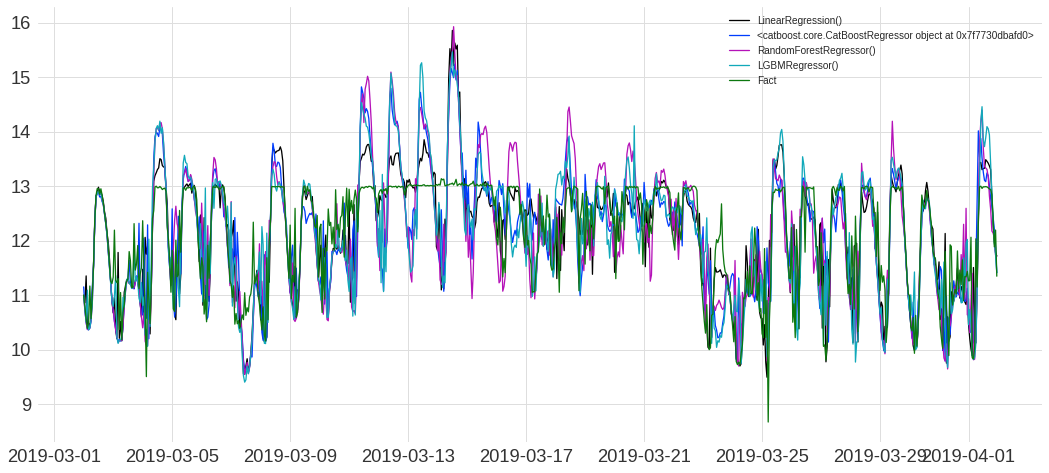

In [71]:
for col in range(len(sol)):
    plt.plot(sol[col].dropna()+tmp.y.loc['2019-03-02':'2019-04-01'], label=sol[col].name)

#plt.plot(tmp.y.loc['2019-03-02':'2019-04-01'], label='Fact', lw=3)
plt.legend()

## Evaluation returns outputs of cost function for each of the models:

In [34]:
EVALUATE = True
print(odm.x.columns, odm.evaluate())

AttributeError: 'OptimalDecisionMakersElectricityPeak' object has no attribute 'optimal_decisions_df'